<a href="https://colab.research.google.com/github/phoneix116/Movie-Reccomendation-Website/blob/main/recsys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import re


from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MultiLabelBinarizer



In [ ]:
dfM = pd.read_csv("movies.csv")
dfM.info()

print()

dfM.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB



,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
# Define a function to clean movie titles (remove special characters)
def clean_title(title):
    return re.sub("[^a-zA-Z0-9 ]", "", title)

# Split the 'genres' column into lists of individual genres
dfM['genres'] = dfM['genres'].str.split('|')

# Clean the 'title' column by applying the 'clean_title' function
dfM['title'] = dfM['title'].apply(clean_title)

# Create a new DataFrame called 'movies_data' with selected columns
movies_data = dfM[['movieId', 'title', 'genres']]

# Get unique genres from all movies
unique_genres = pd.Series([genre for genres_list in movies_data['genres'] for genre in genres_list]).unique()

# Print the first few rows of the 'movies_data' DataFrame
movies_data.head()

,movieId,title,genres
0,1,Toy Story 1995,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji 1995,"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men 1995,"[Comedy, Romance]"
3,4,Waiting to Exhale 1995,"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II 1995,[Comedy]


In [ ]:
# Print the number of unique movie titles
print(f"There are {movies_data['title'].nunique()} Unique Movie Titles")

# Print the number of unique genres
print(f"There are {len(unique_genres)} Movie Genres.")

# Print the list of unique genres
print("Movie Genres:", unique_genres)


There are 62298 Unique Movie Titles
There are 20 Movie Genres.
Movie Genres: ['Adventure' 'Animation' 'Children' 'Comedy' 'Fantasy' 'Romance' 'Drama'
 'Action' 'Crime' 'Thriller' 'Horror' 'Mystery' 'Sci-Fi' 'IMAX'
 'Documentary' 'War' 'Musical' 'Western' 'Film-Noir' '(no genres listed)']


In [ ]:
dfR = pd.read_csv("ratings.csv")

# Print the total number of data points (rows) in the DataFrame
print('Number of Data Points:', len(dfR.iloc[:,1]))

# Print the total number of features (columns) in the DataFrame
print('Number of Features:', len(dfR.iloc[1,:]))  # Using the second row to count features

# Print a formatted string indicating the number of feature columns
print(f'There are {len(dfR.iloc[1,:])} Feature Columns in the Dataset:')

# Print the names of all features (columns) in the DataFrame
print('Feature Names:', dfR.columns.tolist()[:])  # Convert column names to a list and print

# Set pandas display options to show all columns without truncation
pd.options.display.max_columns = None



# Drop timestamp column

dfR = dfR.drop(['timestamp'], axis=1)


dfR.head()
print()
print()
dfR.info()


Number of Data Points: 25000095
Number of Features: 4
There are 4 Feature Columns in the Dataset:
Feature Names: ['userId', 'movieId', 'rating', 'timestamp']


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int64  
 1   movieId  int64  
 2   rating   float64
dtypes: float64(1), int64(2)
memory usage: 572.2 MB


In [ ]:
df = pd.merge(dfR, movies_data, on="movieId")
df.head()

,userId,movieId,rating,title,genres
0,1,296,5.0,Pulp Fiction 1994,"[Comedy, Crime, Drama, Thriller]"
1,1,306,3.5,Three Colors Red Trois couleurs Rouge 1994,[Drama]
2,1,307,5.0,Three Colors Blue Trois couleurs Bleu 1993,[Drama]
3,1,665,5.0,Underground 1995,"[Comedy, Drama, War]"
4,1,899,3.5,Singin in the Rain 1952,"[Comedy, Musical, Romance]"


## **Distribution Of Ratings**

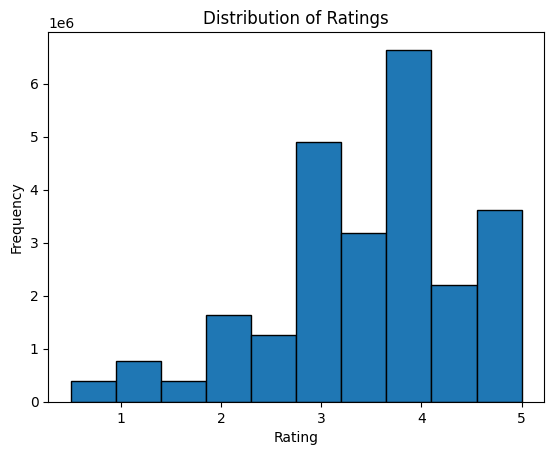

In [ ]:
plt.hist(dfR['rating'], bins=10, edgecolor='black')  # Change to edgecolor
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

# **Histogram of Movie Release Years**

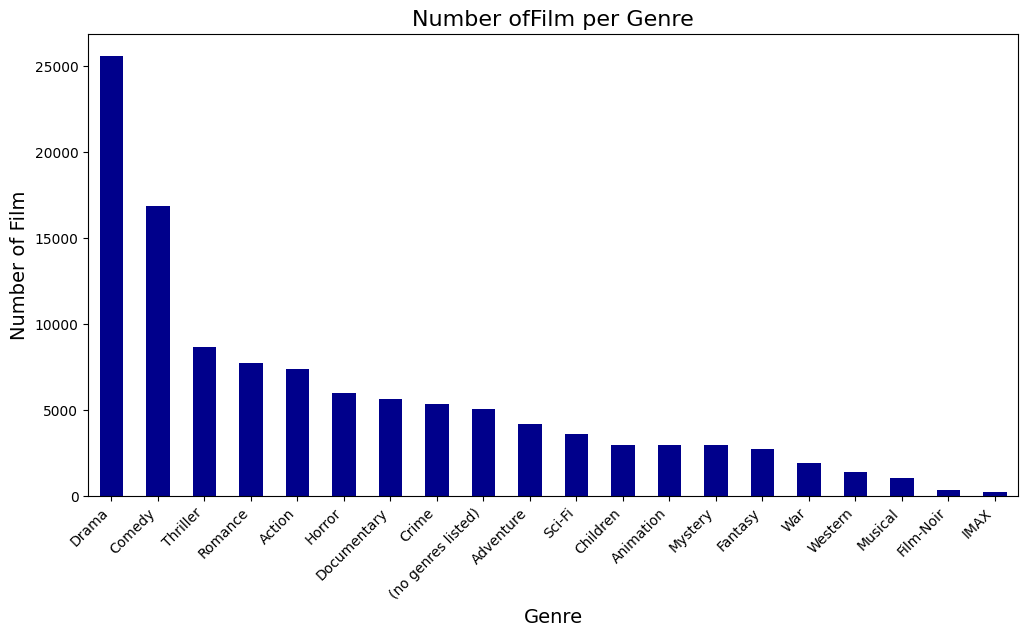

In [ ]:
genre_counts = pd.Series([genre for genres_list in movies_data['genres'] for genre in genres_list]).value_counts()

plt.figure(figsize=(12, 6))
genre_counts.plot(kind='bar', color='darkblue')
plt.title('Number ofFilm per Genre', fontsize=16)
plt.xlabel('Genre', fontsize=14)
plt.ylabel('Number of Film', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
#feature engineering
df.head()




,userId,movieId,rating,title,genres
0,1,296,5.0,Pulp Fiction 1994,"[Comedy, Crime, Drama, Thriller]"
1,1,306,3.5,Three Colors Red Trois couleurs Rouge 1994,[Drama]
2,1,307,5.0,Three Colors Blue Trois couleurs Bleu 1993,[Drama]
3,1,665,5.0,Underground 1995,"[Comedy, Drama, War]"
4,1,899,3.5,Singin in the Rain 1952,"[Comedy, Musical, Romance]"


In [ ]:
def extract_year(title):
    match = re.search(r'\s(\d{4})$', title)  # Search for a 4-digit year
    if match:
        return int(match.group(1))  # Extract the full year and convert to integer
    else:
        return None  # Return None if no year is found

# Apply the function to the 'title' column and create a new 'year' column
df['year'] = df['title'].apply(extract_year)

# Print the updated DataFrame
df.head()

,userId,movieId,rating,title,genres,year
0,1,296,5.0,Pulp Fiction 1994,"[Comedy, Crime, Drama, Thriller]",1994.0
1,1,306,3.5,Three Colors Red Trois couleurs Rouge 1994,[Drama],1994.0
2,1,307,5.0,Three Colors Blue Trois couleurs Bleu 1993,[Drama],1993.0
3,1,665,5.0,Underground 1995,"[Comedy, Drama, War]",1995.0
4,1,899,3.5,Singin in the Rain 1952,"[Comedy, Musical, Romance]",1952.0


In [ ]:
print("No of Missing Values per Coloumn:")
df.isnull().sum()


No of Missing Values per Coloumn:


,0
userId,0
movieId,0
rating,0
title,0
genres,0
year,13519


In [ ]:

# Fill NaN values in the 'year' column with "Not Available"
df['year'] = df['year'].fillna(0)
print("\nNo of Missing Values per Coloumn after filling NaN:")
print(df.isnull().sum())



No of Missing Values per Coloumn after filling NaN:
userId     0
movieId    0
rating     0
title      0
genres     0
year       0
dtype: int64


In [ ]:
# Create a binary feature for movies with no genres
df['no_genres_listed'] = df['genres'].apply(lambda x: 1 if isinstance(x, list) and len(x) == 0 else 0)


# Define all possible genres
all_genres = unique_genres[:-1]

# One-hot e
mlb = MultiLabelBinarizer(classes=all_genres)
genre_encoded = pd.DataFrame(mlb.fit_transform(df['genres']), columns=mlb.classes_)

# Add the no_genres_listed column to the encoded data
genre_encoded['no_genres_listed'] = df['no_genres_listed'].values

# Reset index to ensure proper concatenation
df = df.reset_index(drop=True)
genre_encoded = genre_encoded.reset_index(drop=True)

# Merge one-hot encoded genres back into the main DataFrame
df = pd.concat([df, genre_encoded], axis=1)

# Convert year to numeric if it's not already
df['year'] = df['year'].astype(float)

# Check for duplicate columns
duplicate_cols = df.columns[df.columns.duplicated()]
print(f"Duplicate columns: {duplicate_cols}")

# Drop duplicate columns
df = df.loc[:, ~df.columns.duplicated()]



df.head(10)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['(no genres listed)'] will be ignored
  warnings.warn(


Duplicate columns: Index(['no_genres_listed'], dtype='object')


,userId,movieId,rating,title,genres,year,no_genres_listed,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir
0,1,296,5.0,Pulp Fiction 1994,"[Comedy, Crime, Drama, Thriller]",1994.0,0,0,0,0,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0
1,1,306,3.5,Three Colors Red Trois couleurs Rouge 1994,[Drama],1994.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,1,307,5.0,Three Colors Blue Trois couleurs Bleu 1993,[Drama],1993.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,1,665,5.0,Underground 1995,"[Comedy, Drama, War]",1995.0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
4,1,899,3.5,Singin in the Rain 1952,"[Comedy, Musical, Romance]",1952.0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
5,1,1088,4.0,Dirty Dancing 1987,"[Drama, Musical, Romance]",1987.0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0
6,1,1175,3.5,Delicatessen 1991,"[Comedy, Drama, Romance]",1991.0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
7,1,1217,3.5,Ran 1985,"[Drama, War]",1985.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
8,1,1237,5.0,Seventh Seal The Sjunde inseglet Det 1957,[Drama],1957.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1250,4.0,Bridge on the River Kwai The 1957,"[Adventure, Drama, War]",1957.0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
# Select features for clustering
feature_cols = ['rating', 'year', 'no_genres_listed'] + list(all_genres)
X = df[feature_cols]

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply KMeans with the scaled features
kmeans = KMeans(n_clusters=9, random_state=48, n_init=12)
df['cluster'] = kmeans.fit_predict(X_scaled)

In [ ]:
df[['title', 'cluster']].head(100)

,title,cluster
0,Pulp Fiction 1994,1
1,Three Colors Red Trois couleurs Rouge 1994,3
2,Three Colors Blue Trois couleurs Bleu 1993,3
3,Underground 1995,3
4,Singin in the Rain 1952,3
...,...,...
95,Rock The 1996,0
96,Godfather The 1972,1
97,My Fair Lady 1964,3
98,Its a Wonderful Life 1946,2


In [ ]:
# Analyze cluster characteristics
for cluster_id in range(kmeans.n_clusters):
    cluster_movies = df[df['cluster'] == cluster_id]
    print(f"\nCluster {cluster_id} ({len(cluster_movies)} movies):")
    print(f"Average rating: {cluster_movies['rating'].mean():.2f}")
    print(f"Average year: {cluster_movies['year'].mean():.0f}")

    # Find dominant genres in this cluster
    genre_cols = [col for col in df.columns if col in ['Adventure', 'Animation', 'Children',
                                                     'Comedy', 'Fantasy', 'Romance', 'Drama',
                                                     'Action', 'Crime', 'Thriller', 'Horror',
                                                     'Mystery', 'Sci-Fi', 'IMAX', 'Documentary',
                                                     'War', 'Musical', 'Western', 'Film-Noir']]

    genre_means = cluster_movies[genre_cols].mean().sort_values(ascending=False)
    dominant_genres = genre_means[genre_means > 0.3].index.tolist()
    print(f"Dominant genres: {dominant_genres}")

    # Sample movies from this cluster
    print("Sample movies:")
    cluster_movies[['title', 'year', 'rating']].head(3)



Cluster 0 (4975846 movies):
Average rating: 3.48
Average year: 1997
Dominant genres: ['Action', 'Adventure', 'Sci-Fi', 'Thriller']
Sample movies:

Cluster 1 (3309508 movies):
Average rating: 3.66
Average year: 1996
Dominant genres: ['Crime', 'Drama', 'Thriller', 'Action', 'Comedy']
Sample movies:

Cluster 2 (2037992 movies):
Average rating: 3.51
Average year: 1993
Dominant genres: ['Children', 'Animation', 'Adventure', 'Comedy', 'Fantasy']
Sample movies:

Cluster 3 (10257451 movies):
Average rating: 3.52
Average year: 1994
Dominant genres: ['Drama', 'Comedy', 'Romance']
Sample movies:

Cluster 4 (1718237 movies):
Average rating: 3.76
Average year: 1992
Dominant genres: ['Mystery', 'Thriller', 'Drama', 'Crime']
Sample movies:

Cluster 5 (483652 movies):
Average rating: 3.59
Average year: 1987
Dominant genres: ['Western', 'Drama', 'Action', 'Adventure']
Sample movies:

Cluster 6 (1881757 movies):
Average rating: 3.29
Average year: 1993
Dominant genres: ['Horror', 'Thriller']
Sample movi

In [ ]:
def recommend_movies(movie_title, df, X_scaled, n_recommendations=5):
    # Find the movie's cluster
    movie = df[df['title'].str.contains(movie_title, case=False)]
    if movie.empty:
        return "Movie not found in database"

    movie_cluster = movie['cluster'].values[0]

    # Find other movies in the same cluster
    similar_movies = df[df['cluster'] == movie_cluster]

    # Exclude the input movie
    similar_movies = similar_movies[~similar_movies['title'].str.contains(movie_title, case=False)]

    # Sort by rating and return top n recommendations
    recommendations = similar_movies.sort_values('rating', ascending=False).head(n_recommendations)

    return recommendations[['title', 'rating', 'year', 'genres']]

# Test the recommendation function
recommend_movies("Pulp Fiction", df, X_scaled)


,title,rating,year,genres
24999482,In Bruges 2008,5.0,2008.0,"[Comedy, Crime, Drama, Thriller]"
24999607,Fast and the Furious The 2001,5.0,2001.0,"[Action, Crime, Thriller]"
149,Untouchables The 1987,5.0,1987.0,"[Action, Crime, Drama]"
19,Run Lola Run Lola rennt 1998,5.0,1998.0,"[Action, Crime]"
33,Teddy Bear Mis 1981,5.0,1981.0,"[Comedy, Crime]"


In [ ]:
df.to_csv('df.csv', index=False)  # Save as CSV in Colab VM

from google.colab import files
files.download('df.csv')  # This will prompt a download to your computer


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print(all_genres)


['Adventure' 'Animation' 'Children' 'Comedy' 'Fantasy' 'Romance' 'Drama'
 'Action' 'Crime' 'Thriller' 'Horror' 'Mystery' 'Sci-Fi' 'IMAX'
 'Documentary' 'War' 'Musical' 'Western' 'Film-Noir']
